# Task 1: News Topic Classifier Using BERT

# Problem Statement & Objective

The goal is to build an automated news classification system. By fine-tuning a pre-trained BERT-base-uncased model on the AG News dataset, we aim to categorize headlines into four classes: World, Sports, Business, and Sci/Tech.

In [ ]:
!pip install -q transformers datasets evaluate accelerate streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.5 MB/s eta 0:00:00


#  Dataset Loading & Preprocessing
The AG News dataset contains 120,000 training samples and 7,600 testing samples.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load dataset
dataset = load_dataset("ag_news")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocessing function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize the dataset
tokenized_news = dataset.map(preprocess_function, batched=True)

#  Model Development & Training
We use the Trainer API from Hugging Face for efficiency.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate


import os
os.environ["WANDB_DISABLED"] = "true"
# Load BERT for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# Define Evaluation Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Training Arguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_news["train"].shuffle(seed=42).select(range(10000)), # Sample for speed
    eval_dataset=tokenized_news["test"],
    compute_metrics=compute_metrics,
)

# Start Training
trainer.train()

# Evaluation with Metrics
After training, you should generate a classification report to view the F1-score, as accuracy alone can be misleading in imbalanced sets (though AG News is relatively balanced).

In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(tokenized_news["test"])
preds = np.argmax(predictions.predictions, axis=-1)

print(classification_report(tokenized_news["test"]["label"], preds, target_names=dataset["train"].features["label"].names))

              precision    recall  f1-score   support

       World       0.94      0.91      0.92      1900
      Sports       0.97      0.99      0.98      1900
    Business       0.87      0.89      0.88      1900
    Sci/Tech       0.90      0.88      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



# Lightweight Deployment (Gradio)

In [ ]:
# @title
import gradio as gr

# Define a few real-world examples to show what the app does
example_headlines = [
    ["NVIDIA reveals new AI chip to compete with rivals."], # Sci/Tech
    ["Global markets slide as inflation fears resurface."], # Business
    ["Olympic athletes prepare for final trials this weekend."], # Sports
    ["United Nations calls for immediate ceasefire in conflict zone."] # World
]

# Create the improved interface
interface = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(lines=2, placeholder="Enter a news headline here...", label="News Headline"),
    outputs=gr.Label(num_top_classes=3, label="Topic Prediction"), # Shows confidence bars

    # --- New Layout Features ---
    title="📰 News Topic Classifier (BERT)",
    description="""This application uses a fine-tuned **BERT** model to categorize news headlines.
    It can distinguish between **World**, **Sports**, **Business**, and **Sci/Tech** news.""",
    article="""### How to Use:
1. Type a news headline in the box on the left.
2. Click **Submit** to see the category.
3. Or, click one of the **Examples** below to instantly test the model!""",
    examples=example_headlines, # Adds the clickable samples
    theme="soft" # Changes the look to a more modern "soft" theme
)

interface.launch(share=True)

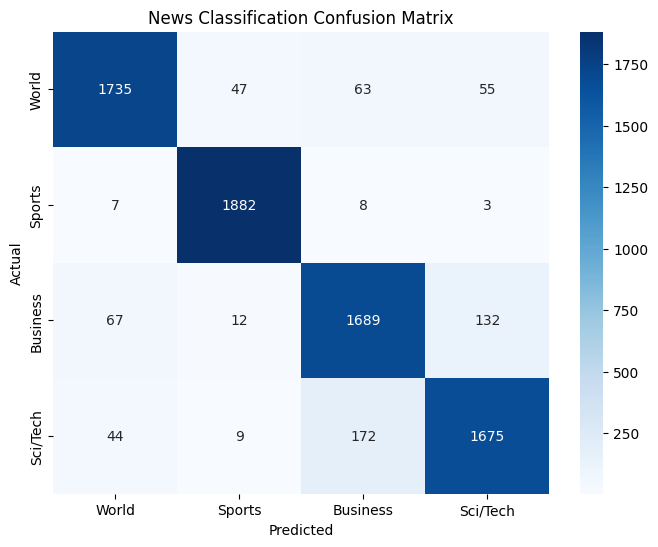

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions on the test set
predictions = trainer.predict(tokenized_news["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = tokenized_news["test"]["label"]

# Create Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset["train"].features["label"].names,
            yticklabels=dataset["train"].features["label"].names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('News Classification Confusion Matrix')
plt.show()

In [ ]:
# Create a directory name
model_path = "./news_classifier_bert"

# Save the model weights and architecture
model.save_pretrained(model_path)

# Save the tokenizer (essential for processing future text the same way)
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to {model_path}")

Model and tokenizer saved to ./news_classifier_bert


In [ ]:
import shutil
from google.colab import files

# 1. Zip the folder
# Syntax: shutil.make_archive(output_filename, 'zip', source_folder_name)
shutil.make_archive('news_classifier_model', 'zip', 'news_classifier_bert')

# 2. Trigger the download to your computer
files.download('news_classifier_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Path to the folder where you extracted the files
# model_path = "./news_classifier_bert"

# # Load the architecture and weights
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

# # Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_path)